# Bibliotecas

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import csv

from glob import glob
import librosa

#Configurando el estilo de los gráficos
from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

# Leemos audio

In [70]:
audio_files = glob('dataset/*.wav')
y, sr = librosa.load(audio_files[0], sr=None)

# Ajustamos audio

In [71]:
y = y - np.mean(y) # Restamos la media para centrar el audio
y = librosa.util.normalize(y) # Normalizamos el audio

# Mostramos el audio leido

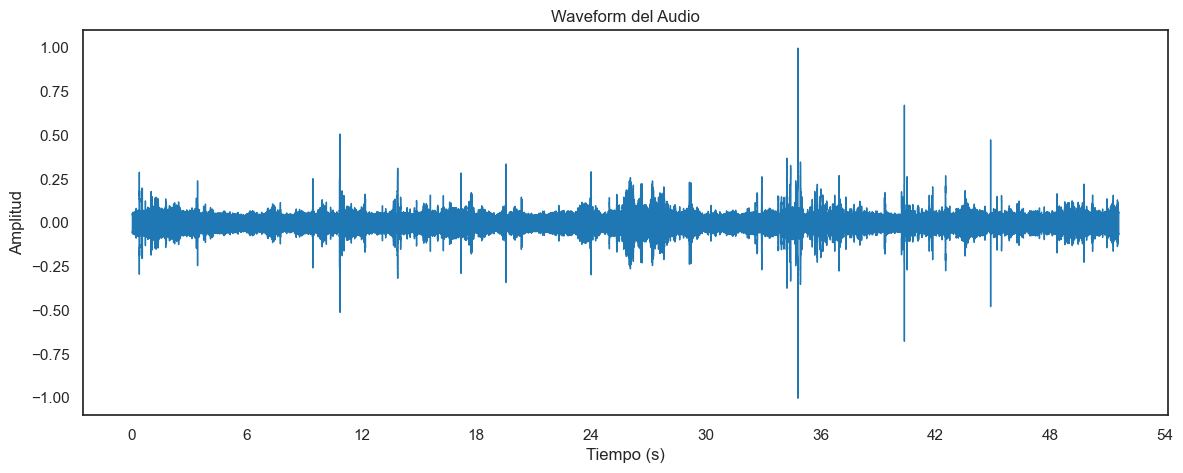

In [72]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform del Audio')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.show()

# Calculamos la transformada rápida de Fourier

In [73]:
#Calculamos la Transformada rapida de Fourier (FFT)
N = len(y)
fhat = np.fft.fft(y)  # Calculamos la FFT
freq = np.fft.fftfreq(N, d=1/sr) # Calculamos las frecuencias asociadas a la FFT
energia = np.abs(fhat)**2  # Calculamos la energia del espectro

# Mostramos la señal en el dominio de las frecuencias

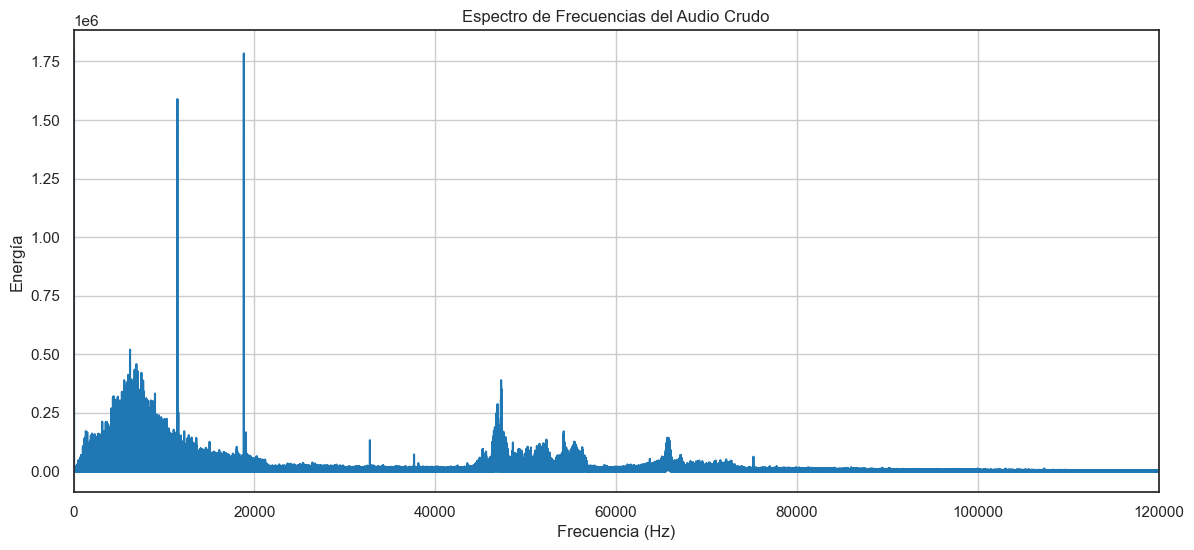

In [74]:
plt.figure(figsize=(14, 6))
plt.plot(freq[:N//2 + 1], energia[:N//2 + 1])  # Graficamos solo la mitad positiva del espectro
plt.xlim(0, 120000)  # Hasta 120 kHz
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Energía')
plt.title('Espectro de Frecuencias del Audio Crudo')
plt.grid(True)
plt.show()


# Filtro pasabanda

Usamos un filtro que nos ayuda a eliminar el audio fuera del rango de frecuencias ultrasonicas

In [75]:
from scipy.signal import butter, filtfilt

# 1. Parámetros
lowcut = 20000  # Hz, corte inferior
highcut = 90000  # Hz, corte superior
order = 5  # orden del filtro (puedes ajustar esto más adelante)

# 2. Normalizamos las frecuencias a la escala de [0,1] donde 1 es Nyquist (sr/2)
nyquist = sr / 2
low = lowcut / nyquist
high = highcut / nyquist

# 3. Creamos el filtro pasa banda
b, a = butter(order, [low, high], btype='bandpass')

# 4. Aplicamos el filtro usando filtfilt (sin desfase)
y_filtrado = filtfilt(b, a, y)

# Corroboramos que el filtro pasabanda haya funcionado

Para lograrlo usamos la transformada rapida de Fourier sobre la señal filtrada, y luego la mostramos en el dominio de las frecuencias

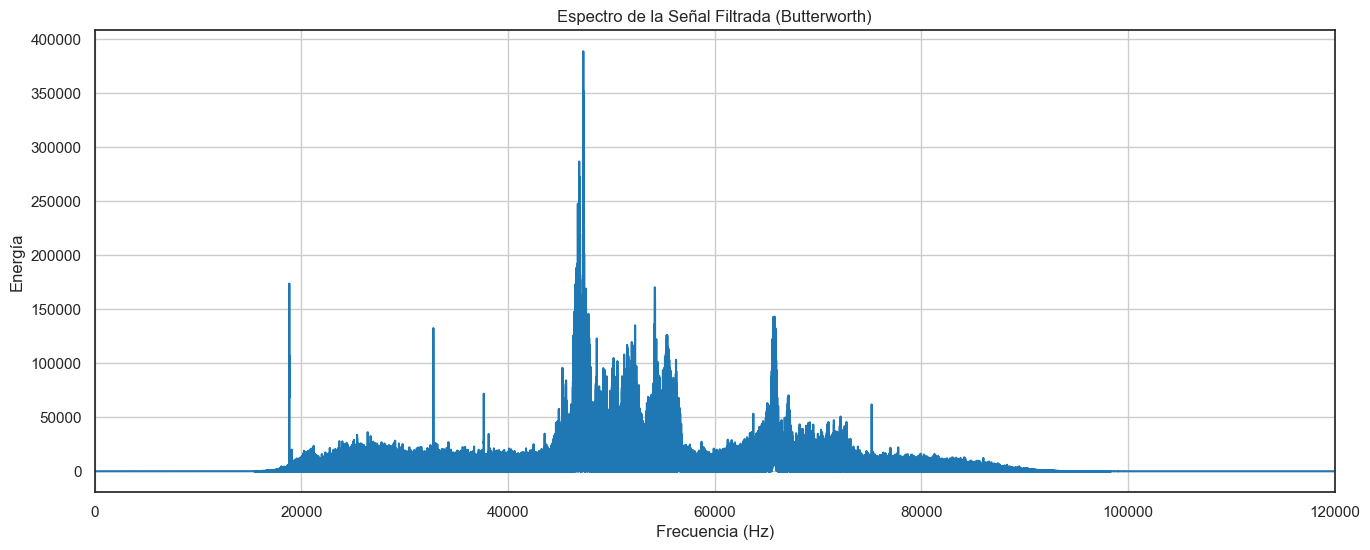

In [76]:
# Calculamos la Transformada rápida de Fourier (FFT) sobre la señal filtrada
N_filtrado = len(y_filtrado)
fhat_filtrado = np.fft.fft(y_filtrado)
energia_filtrada = np.abs(fhat_filtrado)**2 
freq_filtrado = np.fft.fftfreq(N_filtrado, d=1/sr)

plt.figure(figsize=(16, 6))
plt.plot(freq_filtrado[:N//2 + 1], energia_filtrada[:N//2 + 1]) # Graficamos solo la mitad positiva del espectro
plt.xlim(0, 120000) # Hasta 120 kHz
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Energía')
plt.title('Espectro de la Señal Filtrada (Butterworth)')
plt.grid(True)
plt.show()

# Señal original vs Filtrada en el dominio de las frecuencias

Aqui mostramos el audio en el dominio de la frecuencia, antes y despues de ser filtrado

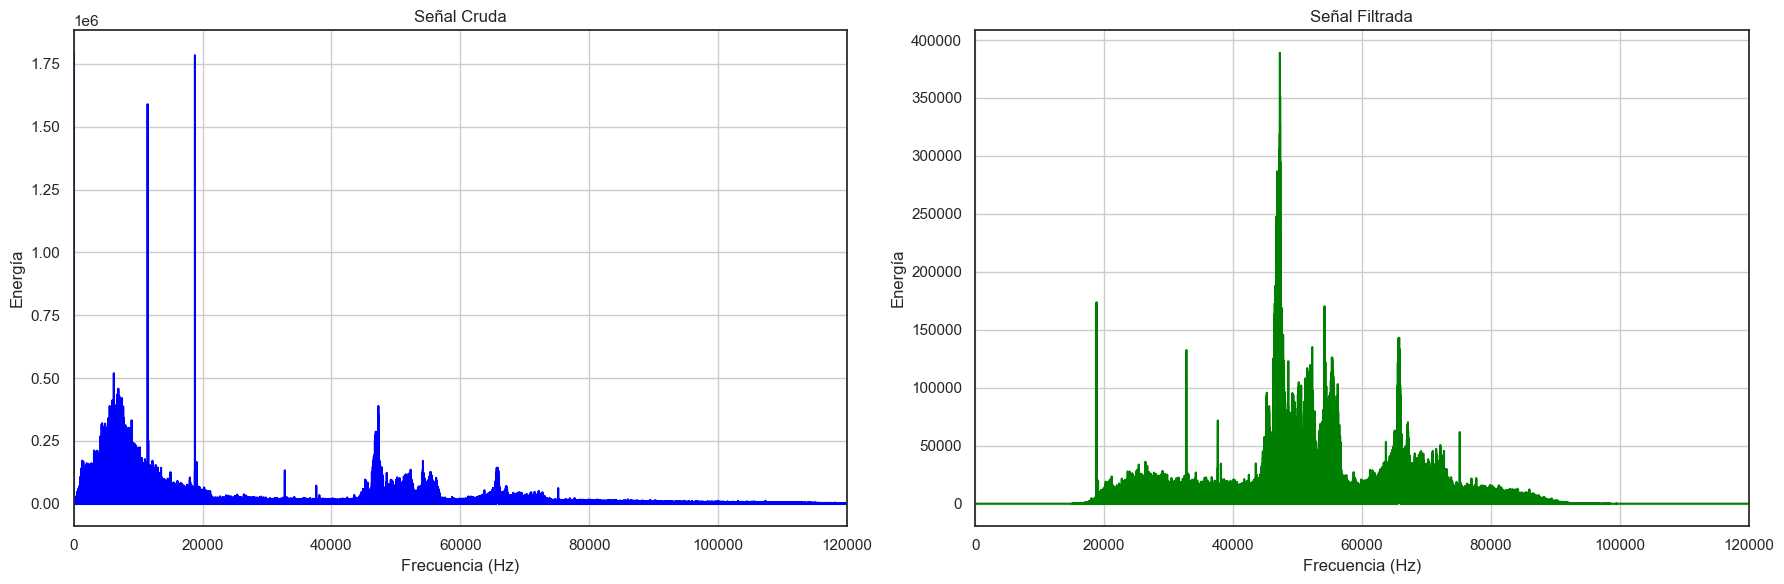

In [77]:
plt.figure(figsize=(18, 6))

# Señal cruda
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(freq[:N//2 + 1], energia[:N//2 + 1], color='blue')
plt.xlim(0, 120000)  # Hasta 120 kHz
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Energía')
plt.title('Señal Cruda')
plt.grid(True)

# Señal filtrada
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(freq_filtrado[:N//2 + 1], energia_filtrada[:N//2 + 1], color='green')
plt.xlim(0, 120000)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Energía')
plt.title('Señal Filtrada')
plt.grid(True)

# Mostrar todo junto
plt.tight_layout()
plt.show()

# Señal original vs Filtrada en el dominio del tiempo

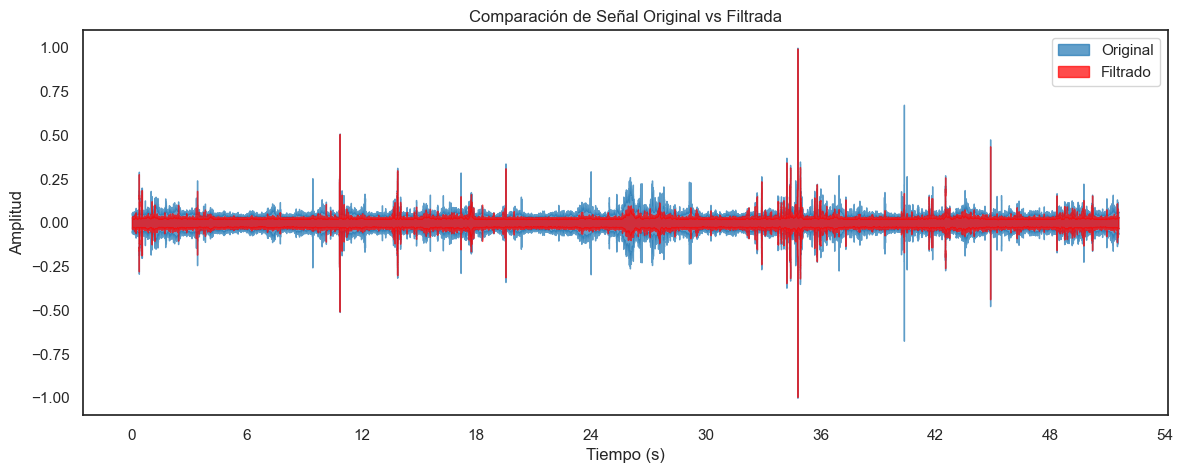

In [78]:
t = np.arange(len(y_filtrado)) / sr

plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr, alpha=0.7, label='Original')
librosa.display.waveshow(y_filtrado, sr=sr, color='r', alpha=0.7, label='Filtrado')
plt.title('Comparación de Señal Original vs Filtrada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

# Mostramos espectrograma de 1 seg

Usamos solo 1 segundo de la señal para que logremos distinguir las silabas

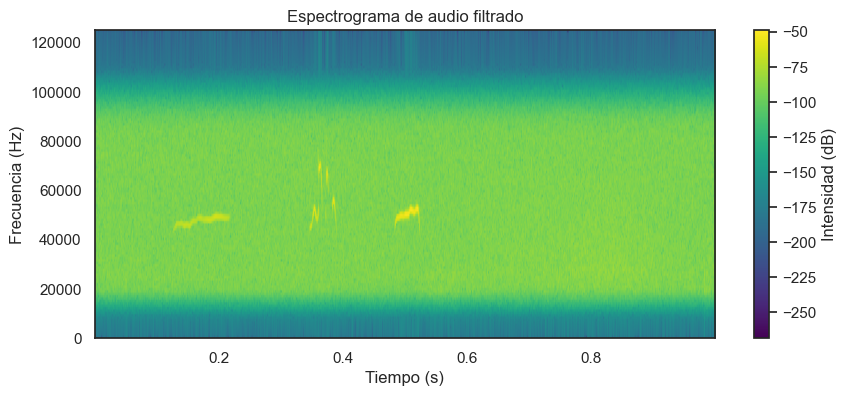

In [79]:
plt.figure(figsize=(10, 4))
plt.specgram(y_filtrado[:250000], NFFT=256, Fs=sr, noverlap=128, cmap='viridis')
plt.title('Espectrograma de audio filtrado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia (Hz)')
plt.colorbar(label='Intensidad (dB)')
plt.show()

# Dividimos por ventanas de 5ms

Con el objetivo de encontrar todas las posibles silbas del audio, lo que haremos será dividir el audio en fragmentos de 5ms en los que luego analizaremos su espectro de frecuencias, asi, iremos colectando "ventanas activas"

In [80]:
# Parámetros
duracion_ventana = 5  # ms
solapamiento = 0.5

tamano_ventana = int((duracion_ventana / 1000) * sr)
salto_ventana = int(tamano_ventana * (1 - solapamiento))
cantidad_ventanas = (len(y_filtrado) - tamano_ventana) // salto_ventana + 1

# Rango ultrasónico
ultra_low = 20000
ultra_high = 90000

frequencies = np.fft.rfftfreq(tamano_ventana, d=1/sr)
band_indices = np.where((frequencies >= ultra_low) & (frequencies <= ultra_high))[0]
fft_band_frequencies = frequencies[band_indices]

# Definir tamaño del subbloque espectral (por ejemplo, 2 kHz)
subbloque_ancho_hz = 2000
subbloque_bins = int(subbloque_ancho_hz / (sr / tamano_ventana))

ventanas_activas = []
suma_subbloques_todas = []

for i in range(cantidad_ventanas):
    inicio = i * salto_ventana
    fin = inicio + tamano_ventana
    ventana = y_filtrado[inicio:fin]

    # FFT magnitudes
    fft_magnitudes = np.abs(np.fft.rfft(ventana))
    fft_band = fft_magnitudes[band_indices]

    # Dividir banda ultrasónica en bloques y sumar energía por bloque
    suma_subbloques = []
    for j in range(0, len(fft_band), subbloque_bins):
        bloque = fft_band[j:j + subbloque_bins]
        suma_subbloques.append(np.sum(bloque))
    
    suma_subbloques_todas.extend(suma_subbloques)  # para estadística global

# Calcular umbral global por subbloque (media + n*std)
n = 2  # ajutar la sensibilidad
suma_subbloques_todas = np.array(suma_subbloques_todas)
media_global = np.mean(suma_subbloques_todas)
std_global = np.std(suma_subbloques_todas)
umbral = media_global + n * std_global

print(f"Umbral energético por subbloque: {umbral}")

# Repetir recorrido para marcar ventanas activas
for i in range(cantidad_ventanas):
    inicio = i * salto_ventana
    fin = inicio + tamano_ventana
    ventana = y_filtrado[inicio:fin]

    # FFT magnitudes
    fft_magnitudes = np.abs(np.fft.rfft(ventana))
    fft_band = fft_magnitudes[band_indices]

    # Revisar si algún subbloque supera el umbral
    activa = 0
    for j in range(0, len(fft_band), subbloque_bins):
        bloque = fft_band[j:j + subbloque_bins]
        suma_bloque = np.sum(bloque)
        if suma_bloque > umbral:
            activa = 1
            break

    ventanas_activas.append(activa)

print(f"Total de ventanas analizadas: {cantidad_ventanas}")
print(f"Ventanas activas detectadas: {sum(ventanas_activas)}")

Umbral energético por subbloque: 12.364674727509023
Total de ventanas analizadas: 20627
Ventanas activas detectadas: 1139


# Determinamos cuantas y cuales son las silbas detectadas

Una vez que hemos determinado las ventanas "activas", haremos la union de las ventanas consecutivas activas para decir que se trata de una "silaba", luego, tambien buscaremos unir las silabas que se encuentren a menos de 21ms de distancia.

In [81]:
# Primero agrupamos ventanas consecutivas en sílabas
silabas_detectadas = []
en_silaba = False
inicio_silaba = None

for i, activa in enumerate(ventanas_activas):
    if activa == 1 and not en_silaba:
        en_silaba = True
        inicio_silaba = i
    elif activa == 0 and en_silaba:
        fin_silaba = i - 1
        silabas_detectadas.append((inicio_silaba, fin_silaba))
        en_silaba = False

if en_silaba:
    fin_silaba = len(ventanas_activas) - 1
    silabas_detectadas.append((inicio_silaba, fin_silaba))

# Ahora fusionamos sílabas separadas por menos de 21 ms
min_separacion_ms = 21
min_separacion_ventanas = int(min_separacion_ms / (salto_ventana * 1000 / sr))

silabas_fusionadas = []
i = 0
while i < len(silabas_detectadas):
    inicio, fin = silabas_detectadas[i]
    while (i + 1 < len(silabas_detectadas)) and (silabas_detectadas[i + 1][0] - fin <= min_separacion_ventanas):
        # Fusionar con la siguiente sílaba
        fin = silabas_detectadas[i + 1][1]
        i += 1
    silabas_fusionadas.append((inicio, fin))
    i += 1

print(f"Sílaba(s) finales detectadas después de fusión: {len(silabas_fusionadas)}")

# Guardar detalles por sílaba en un archivo CSV
with open('detalles_silabas.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Silaba', 'Inicio (s)', 'Fin (s)', 'Duracion (ms)'])  # Escribir encabezados

    for idx, (inicio, fin) in enumerate(silabas_fusionadas):
        tiempo_inicio = inicio * salto_ventana / sr
        tiempo_fin = (fin + 1) * salto_ventana / sr
        duracion = tiempo_fin - tiempo_inicio
        writer.writerow([idx + 1, f"{tiempo_inicio:.4f}", f"{tiempo_fin:.4f}", f"{duracion * 1000:.1f}"])

print("Detalles de las sílabas guardados en 'detalles_silabas.csv'")


Sílaba(s) finales detectadas después de fusión: 96
Detalles de las sílabas guardados en 'detalles_silabas.csv'
